In this tutorial, I want to illustrate how to use Pyro's [Gaussian Processes module](http://docs.pyro.ai/en/stable/contrib.gp.html) to create and train some deep Gaussian Process models. For the background on how to use this module, readers can check out some tutorials at http://pyro.ai/examples/.

The first part is a fun example to run HMC with a 2-layer regression GP models while the second part uses SVI to classify digit numbers.

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set()
from scipy.cluster.vq import kmeans2

import torch
import torch.nn as nn
from torch.distributions import constraints
from torch.distributions.transforms import AffineTransform
from torchvision import transforms

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
from pyro.contrib.examples.util import get_data_loader
from pyro.infer import MCMC, NUTS, Predictive, SVI, TraceMeanField_ELBO

pyro.set_rng_seed(0)
warnings.formatwarning = (lambda message, category, *args, **kwargs:
                          "{}: {}\n".format(category.__name__, message))

## HMC with Heaviside data

Let's create a dataset from [Heaviside step function](https://en.wikipedia.org/wiki/Heaviside_step_function).

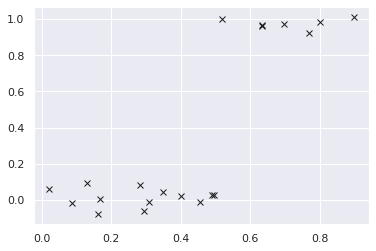

In [2]:
N = 20
X = torch.rand(N)
y = (X >= 0.5).float() + torch.randn(N) * 0.05
plt.plot(X.numpy(), y.numpy(), "kx");

We will make a 2-layer regression model.
<!-- TEASER_END -->

In [3]:
class DeepGPR(pyro.nn.PyroModule):
    def __init__(self, gpr1, gpr2):
        super().__init__()
        self.gpr1 = gpr1
        self.gpr2 = gpr2

    def forward(self):
        h_loc, h_var = self.gpr1.model()
        self.gpr2.X = pyro.sample("h", dist.Normal(h_loc, h_var.sqrt()))
        self.gpr2.model()

# mean function is used as in [3]
gpr1 = gp.models.GPRegression(X, None, gp.kernels.RBF(1), noise=torch.tensor(1e-3),
                              mean_function=lambda x: x)
gpr1.kernel.variance = pyro.nn.PyroSample(dist.Exponential(1))
gpr1.kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))

gpr2 = gp.models.GPRegression(torch.zeros(N), y, gp.kernels.RBF(1), noise=torch.tensor(1e-3))
gpr2.kernel.variance = pyro.nn.PyroSample(dist.Exponential(1))
gpr2.kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))
gpmodel = DeepGPR(gpr1, gpr2)

Now, we run HMC to get 100 samples.

In [4]:
hmc_kernel = NUTS(gpmodel, max_tree_depth=5)
mcmc = MCMC(hmc_kernel, num_samples=200)
mcmc.run()

Sample: 100%|██████████| 400/400 [01:14,  5.34it/s, step size=2.72e-02, acc. prob=0.933]


And plot the marginal distribution of each latent site.

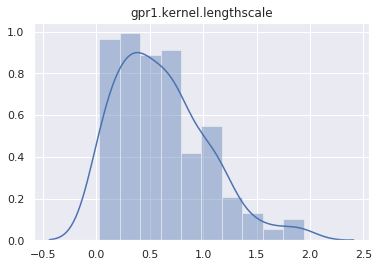

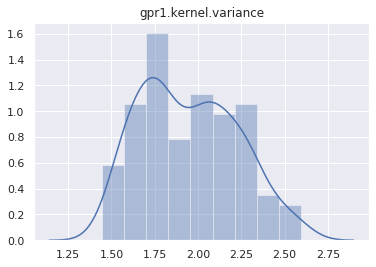

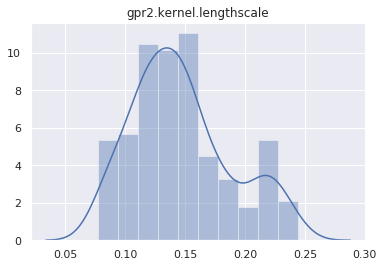

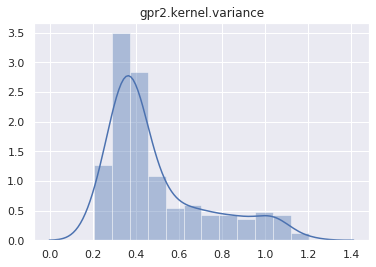

In [5]:
for name, support in mcmc.get_samples().items():
    if name == "h":
        continue
    sns.distplot(support)
    plt.title(name)
    plt.show()

Let's test if the posterior can predict the Heaviside data. The first step is to make a predictive model.

In [6]:
def predictive(X_new):
    # this sample statement will be replaced by a posterior sample `h`
    h = pyro.sample("h", dist.Normal(torch.zeros(N), 1))
    gpr1.y = h
    gpr2.X = h
    h_new_loc, _ = gpr1(X_new)
    y_loc, _ = gpr2(h_new_loc)
    pyro.sample("y", dist.Delta(y_loc))

We will get predictions from this `predictive` model by using samples from `posterior`.

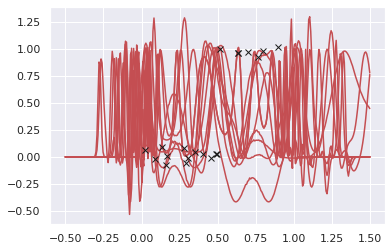

In [7]:
X_test = torch.linspace(-0.5, 1.5, 300)
posterior_predictive = Predictive(predictive, mcmc.get_samples())
y_pred = posterior_predictive.get_samples(X_test)["y"].detach()

# plot 10 predictions
idx = np.random.randint(0, 100, 10)
for i in range(10):
    plt.plot(X_test.numpy(), y_pred[idx[i]].numpy(), 'r-')
plt.plot(X.numpy(), y.numpy(), "kx");

Unfortunately, HMC seems to not play well with this deep GP setting. I don't know how to make it works. Probably I should use sparse GP models...

## SVI with MNIST data

First, we download the MNIST data.

In [8]:
train_loader = get_data_loader(dataset_name='MNIST',
                               data_dir='~/.data',
                               batch_size=1000,
                               is_training_set=True,
                               shuffle=True)
test_loader = get_data_loader(dataset_name='MNIST',
                              data_dir='~/.data',
                              batch_size=1000,
                              is_training_set=False,
                              shuffle=False)

downloading data
download complete.
downloading data
download complete.


In [9]:
X = train_loader.dataset.data.reshape(-1, 784).float() / 255
y = train_loader.dataset.targets

Now, we initialize inducing points for the first layer by using k-mean of X. It is not necessary though, and taking a random subset of X also works.

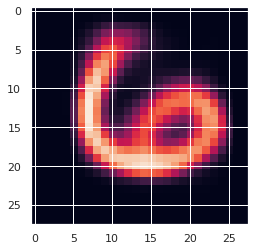

In [10]:
Xu = torch.from_numpy(kmeans2(X.numpy(), 100, minit='points')[0])
# let's plot one of the inducing points
plt.imshow(Xu[0].reshape(28, 28));

In addition, as mentioned in the section "Further Model Details" of [2], a linear mean function is required. We follow the same approach here.

In [11]:
class LinearT(nn.Module):
    """Linear transform and transpose"""
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.linear = nn.Linear(dim_in, dim_out, bias=False)

    def forward(self, x):
        return self.linear(x).t()

# computes the weight for mean function of the first layer;
# it is PCA of X (from 784D to 30D).
_, _, V = np.linalg.svd(X.numpy(), full_matrices=False)
W = torch.from_numpy(V[:30, :])

mean_fn = LinearT(784, 30)
mean_fn.linear.weight.data = W
mean_fn.linear.weight.requires_grad_(False);

Now, we create a deep GP model by stacking 2 variational sparse layers. The first layer includes a mean function (which is defined as above), while the second layer includes a multi-class likelihood. Note that inducing inputs of second layer are initialized by taking the output of mean function on inducing inputs from first layer.

In [12]:
class DeepGP(pyro.nn.PyroModule):
    def __init__(self, X, y, Xu, mean_fn):
        super(DeepGP, self).__init__()
        self.layer1 = gp.models.VariationalSparseGP(
            X,
            None,
            gp.kernels.RBF(784, variance=torch.tensor(2.), lengthscale=torch.tensor(2.)),
            Xu=Xu,
            likelihood=None,
            mean_function=mean_fn,
            latent_shape=torch.Size([30]))
        # make sure that the input for next layer is batch_size x 30
        h = mean_fn(X).t()
        hu = mean_fn(Xu).t()
        self.layer2 = gp.models.VariationalSparseGP(
            h,
            y,
            gp.kernels.RBF(30, variance=torch.tensor(2.), lengthscale=torch.tensor(2.)),
            Xu=hu,
            likelihood=gp.likelihoods.MultiClass(num_classes=10),
            latent_shape=torch.Size([10]))

    def model(self, X, y):
        self.layer1.set_data(X, None)
        h_loc, h_var = self.layer1.model()
        # approximate with a Monte Carlo sample (formula 15 of [1])
        h = dist.Normal(h_loc, h_var.sqrt())()
        self.layer2.set_data(h.t(), y)
        self.layer2.model()

    def guide(self, X, y):
        self.layer1.guide()
        self.layer2.guide()

    # make prediction
    def forward(self, X_new):
        # because prediction is stochastic (due to Monte Carlo sample of hidden layer),
        # we make 100 prediction and take the most common one (as in [4])
        pred = []
        for _ in range(100):
            h_loc, h_var = self.layer1(X_new)
            h = dist.Normal(h_loc, h_var.sqrt())()
            f_loc, f_var = self.layer2(h.t())
            pred.append(f_loc.argmax(dim=0))
        return torch.stack(pred).mode(dim=0)[0]

During early iterations of training process, we want to play more weight on mean function, which is PCA of the input, and reduce the effect of the first layer's kernel. To achieve that, we'll force the inducing outputs of the first layer to be small by setting small initial `u_scale_tril`.

In [13]:
deepgp = DeepGP(X, y, Xu, mean_fn)
deepgp.layer1.u_scale_tril = deepgp.layer1.u_scale_tril * 1e-5
deepgp.cuda()

optimizer = torch.optim.Adam(deepgp.parameters(), lr=0.01)
loss_fn = TraceMeanField_ELBO().differentiable_loss

Now, we make some utitilies to train and test our model, just like other PyTorch models.

In [14]:
def train(train_loader, gpmodule, optimizer, loss_fn, epoch):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        data = data.reshape(-1, 784)
        optimizer.zero_grad()
        loss = loss_fn(gpmodule.model, gpmodule.guide, data, target)
        loss.backward()
        optimizer.step()
        idx = batch_idx + 1
        if idx % 10 == 0:
            print("Train Epoch: {:2d} [{:5d}/{} ({:2.0f}%)]\tLoss: {:.6f}"
                  .format(epoch, idx * len(data), len(train_loader.dataset),
                          100. * idx / len(train_loader), loss))

def test(test_loader, gpmodule):
    correct = 0
    for data, target in test_loader:
        data, target = data.cuda(), target.cuda()
        data = data.reshape(-1, 784)
        pred = gpmodule(data)
        # compare prediction and target to count accuaracy
        correct += pred.eq(target).long().cpu().sum().item()

    print("\nTest set: Accuracy: {}/{} ({:.2f}%)\n"
          .format(correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))

Here I just run 20 steps to illustrate the process.

In [15]:
for i in range(20):
    train(train_loader, deepgp, optimizer, loss_fn, i)
    with torch.no_grad():
        test(test_loader, deepgp)

Train Epoch:  0 [10000/60000 (17%)]	Loss: 212735.531250
Train Epoch:  0 [20000/60000 (33%)]	Loss: 210797.875000
Train Epoch:  0 [30000/60000 (50%)]	Loss: 198544.937500
Train Epoch:  0 [40000/60000 (67%)]	Loss: 188923.781250
Train Epoch:  0 [50000/60000 (83%)]	Loss: 173786.343750
Train Epoch:  0 [60000/60000 (100%)]	Loss: 141733.687500

Test set: Accuracy: 8561/10000 (85.61%)

Train Epoch:  1 [10000/60000 (17%)]	Loss: 97287.031250
Train Epoch:  1 [20000/60000 (33%)]	Loss: 70768.703125
Train Epoch:  1 [30000/60000 (50%)]	Loss: 57853.875000
Train Epoch:  1 [40000/60000 (67%)]	Loss: 52993.148438
Train Epoch:  1 [50000/60000 (83%)]	Loss: 50858.843750
Train Epoch:  1 [60000/60000 (100%)]	Loss: 46951.226562

Test set: Accuracy: 9367/10000 (93.67%)

Train Epoch:  2 [10000/60000 (17%)]	Loss: 48359.058594
Train Epoch:  2 [20000/60000 (33%)]	Loss: 47204.945312
Train Epoch:  2 [30000/60000 (50%)]	Loss: 46667.531250
Train Epoch:  2 [40000/60000 (67%)]	Loss: 45861.250000
Train Epoch:  2 [50000/60000

In [4], the authors run 2-layer Deep GP for more than 300 epochs and achieve 97,94% accuaracy. Despite that stacking many layers can improve performance of Gaussian Processes, it seems to me that following the line of deep kernels is a more reliable approach. Kernels, which are usually underrated, are indeed the core of Gaussian Processes. As demonstrated in [Pyro's Deep Kernel Learning example](http://pyro.ai/examples/dkl.html), we can achieve a state-of-the-art result without having to tuning hyperparameters or using many tricks as in the above example (e.g. fixing a linear mean function, reducing the kernel effect of the first layer).

### References

[1] `MCMC for Variationally Sparse Gaussian Processes` [arxiv](https://arxiv.org/abs/1506.04000)<br/>
James Hensman, Alexander G. de G. Matthews, Maurizio Filippone, Zoubin Ghahramani

[2] `Doubly Stochastic Variational Inference for Deep Gaussian Processes` [arxiv](https://arxiv.org/abs/1705.08933)<br/>
Hugh Salimbeni, Marc Peter Deisenroth

[3] https://github.com/ICL-SML/Doubly-Stochastic-DGP/blob/master/demos/demo_step_function.ipynb

[4] https://github.com/ICL-SML/Doubly-Stochastic-DGP/blob/master/demos/demo_mnist.ipynb